In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import LinearOperator
from scipy.fft import fft2, ifft2
from scipy.optimize import minimize
from sklearn import datasets

Consider retrieving $x \in \mathbb{C}^n$ from measurements

$$y = \mathcal{A}(x) + \epsilon,$$

by solving

$$\min_z J(z), \quad J(z)  = \|\mathcal{A}\circ \mathcal{G} (z) - y\|_2^2 + \lambda^2\|z\|_2^2,$$

where $\mathcal{G}$ is a generative model.

The gradient of $J$ is given by

$$\nabla J(z) = \left(\mathcal{G}'(z)\right)^*\left(\mathcal{A}'(x)\right)^*\left(\mathcal{A}\circ \mathcal{G} (z) - y\right),$$

with $x = \mathcal{G}(z)$ and $\mathcal{G}'(z)$ the Jacobian of $\mathcal{G}$ and $\mathcal{A}'(x)$ the Jacobian of $\mathcal{A}$. 

We typically consider 

$$\mathcal{A}(x) = |Ax|^2,$$

for some given matrix $A \in \mathbb{C}^{m\times n}$. In that case we have

$$\mathcal{A}'(x) = 2\text{diag}(Ax)\overline{A}.$$

We take $A$ to be a masked Fourier transform, in which case it is given by

$$A = \left(\begin{matrix} FM_1 \\ FM_2 \\ \vdots \\ FM_m\end{matrix}\right),$$

with $F \in \mathbb{C}^{n\times n}$ the 2D Fourier transform and $M_i \in \mathbb{C}^{n\times n}$ a diagonal matrix containing a mask.

A simple generative model can be obtained as

$$\mathcal{G}(z) = \mu + Sz, $$

with $\mu$ the mean of the training samples, and $S$ a Cholesky factorisation of the sample covariance matrix (i.e., $\Sigma = SS^*$.)

We can also let $\mathcal{G}(z) = z$ and $\mathcal{G}(z) = \mu + Sz_1 + z_2$.

In [3]:
class Op:
    def __init__(self, fun, jac, shape):
        self.eval = fun
        self.jac = jac
        self.shape = shape
        
def objective(z, y, A, G, w=1, lmbda = 0):
    """
    LS objective
        (0.5)*\|A(G(z)) - y\|_2^2 + 0.5*lmbda**2*\|w*z\|_2^2
    """
    if len(y) != A.shape[0]:
        print("y and A don't match")
        return
    if len(z)//2 != G.shape[1]:
        print("z and G don't match")
        return
    if A.shape[1] != G.shape[0]:
        print("A and G don't match!")
        return
    
    k  = len(z)//2
    zc = z[:k] + 1j*z[k:]
    
    xc = G.eval(zc)
    Dx = G.jac(zc)
    
    yp = A.eval(xc)
    Dy = A.jac(xc)

    val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2
    gradc  = Dx.H@(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*zc

    # print("val", val)
    # print("first element gradc", gradc[0])
    
    grad  = np.concatenate((np.real(gradc), np.imag(gradc)))
    
    return val, grad

def reconstruct(xtrue, A, G, w=1, sigma=0, lmbda=0):
    # sizes
    m,n = A.shape
    n,k = G.shape
    
    # generate data
    yobs  = A.eval(xtrue) + sigma*np.random.randn(m)

    # inference
    #result = minimize(objective, x0=np.ones(2*k), args=(yobs, A, G, w, lmbda), method='L-BFGS-B', jac=True)
    result = minimize(objective, x0=np.ones(2*k), args=(yobs, A, G, w, lmbda), method='L-BFGS-B', jac=True, options={
        'maxiter': 10000,      # total outer iterations
        'maxls': 40,          # line search steps per iteration
        'ftol' : 1e-14,
        'gtol': 1e-14,         # gradient tolerance
        'disp': True          # print optimization log
    })
    
    # result
    zhat = result.x[:k] + 1j*result.x[k:]
    xhat = G.eval(zhat)

    # display information
    # print("zhat", zhat)
    # print("xhat", xhat)

    # print("Result message:", result.message)
    # print("Result status:", result.status)
    # print("Function evals:", result.nfev)
    # print("Jacobian evals:", result.njev)
    # print("Final gradient norm:", np.linalg.norm(result.jac))
    
    # correct global phase
    phi = np.mean(np.angle(xtrue/xhat))
    xhat_corr = np.exp(1j*phi)*xhat
    
    # relative error
    error = np.linalg.norm(xhat_corr - xtrue)/np.linalg.norm(xtrue)
    
    # return
    return error, xhat_corr, yobs, zhat # note before this was result

def plot_result(xtrue, xhat):
    n  = len(xtrue)
    nx = int(np.sqrt(n))
    
    # plot results
    fig, ax = plt.subplots(2,2)

    ax[0,0].imshow(np.real(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[0,0].set_title(r'$\Re(x_{true})$')
    ax[1,0].imshow(np.imag(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[1,0].set_title(r'$\Im(x_{true})$')
    ax[0,1].imshow(np.real(xhat.reshape((nx,nx))),clim=[0,1])
    ax[0,1].set_title(r'$\Re(x_{est})$')
    ax[1,1].imshow(np.imag(xhat.reshape((nx,nx))),clim=[0,1])
    ax[1,1].set_title(r'$\Im(x_{est})$')

    fig.tight_layout()

In [4]:
def MaskedFourier(M):
    """
    Defined masked 2D fourier transform as linear operator.
    
    input:
        M - 3D array of size n x n x m containing m masks of size n x n
        
    out:
        A - linear operator representing the masked Fourier transforms
        
    
    """
    nx = M.shape[0]
    mx = M.shape[2]
    
    mv  = lambda x : fft2(M*(x.reshape((nx,nx,1))), axes=(0,1)).flatten()
    rmv = lambda y : nx*nx*np.sum(np.conj(M)*ifft2(y.reshape((nx,nx,mx)), axes=(0,1)),axis=2).flatten()
    A   = LinearOperator((mx*nx*nx, nx*nx), matvec=mv, rmatvec=rmv)
    
    return A

In [15]:
# load data set of 3's (8 x 8, 183 images)
(digits, cls) = datasets.load_digits(return_X_y=True)
X = np.ones((183, 64)) + 1j*digits[np.where(cls==3)[0],:]/16

n = X.shape[1]
nx = int(np.sqrt(n))

#np.save('MNIST_64_only3.npy', X) # save exact same data 

In [5]:
# load data set of 3's (10 x 10, 6131 images)
X = np.load('MNIST_100_only3_train.npy')
dataset_size = X.shape[0]
X = X.reshape((dataset_size, -1))

n = X.shape[1]
nx = int(np.sqrt(n))

print(X.shape)

# verification images
X_test = np.load('MNIST_100_only3_test.npy')
test_size = X_test.shape[0]
X_test = X_test.reshape((test_size, -1))

(6131, 100)


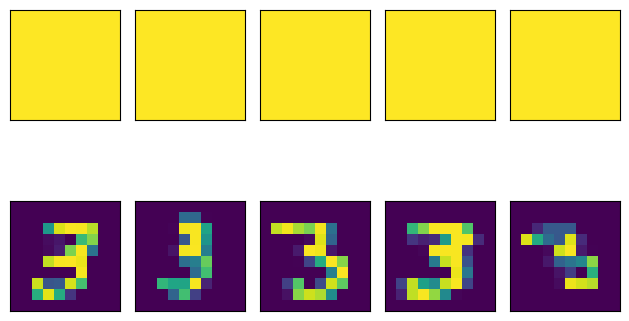

In [6]:
ns = 5
fig, ax = plt.subplots(2,ns)

for i in range(ns):
    x = X[i]
    ax[0,i].imshow(np.real(x).reshape((nx,nx)),clim=[0,1])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((nx,nx)),clim=[0,1])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout()

#plt.savefig('example1_data.png',dpi=300)

In [7]:
# get prior
mu    = np.mean(X,axis=0)
Sigma = np.conj((X-mu).T)@(X-mu)/X.shape[0]
s, U = np.linalg.eigh(Sigma + 1e-6*np.eye(n))

k = 10
B = U[:,-k:]@np.diag(np.sqrt(s[-k:]))

C = np.concatenate((np.real(B), np.eye(n)), axis=1)

# define generative models
G = Op(fun = lambda z : mu + B@z, jac = lambda z : LinearOperator((n, k), matvec = lambda z : B@z, rmatvec = lambda z : np.conj(B.T)@z), shape=(n,k))
I = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : z, rmatvec = lambda z : z), shape=(n,n))
H = Op(fun = lambda z : mu + C@z, jac = lambda z : LinearOperator((n, k+n), matvec = lambda z : C@z, rmatvec = lambda z : np.conj(C.T)@z), shape=(n,k+n))

# define weights
w = 1

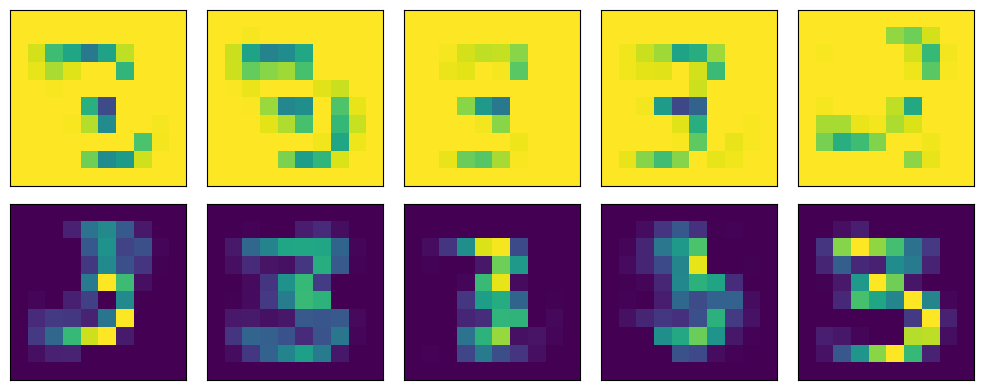

In [8]:
ns = 5
fig, ax = plt.subplots(2,ns, figsize=(10,4))

for i in range(ns):
    z = np.random.randn(k) + 1j*np.random.randn(k)
    x = G.eval(z)
    ax[0,i].imshow(np.real(x).reshape((nx,nx)),clim=[0,1])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((nx,nx)),clim=[0,1])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout()

fig.subplots_adjust(hspace=0.1)

#np.save('outputPCA', x)

#plt.savefig('example1_generative.png',dpi=300)

In [9]:
# define forward operator
mx = 100
m  = mx * n

M = np.random.randn(nx,nx,mx)
M[M<0]=0
M[M>0]=1

MF   = MaskedFourier(M)
Afun = lambda x : np.abs(MF@x)**2
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : 2*(MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : 2*(MF.H@((MF@x)*z)))
#Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : 2*(MF@x)*(np.conj(MF)@z), rmatvec=lambda z : 2*(MF.H@((MF@x)*z)))


A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

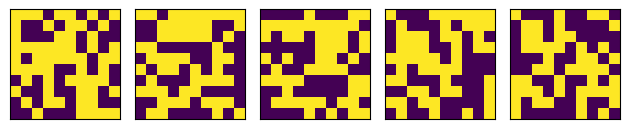

In [8]:
# plot some of the masks
ns = 5
fig, ax = plt.subplots(1,ns)

for i in range(ns):
    z = np.random.randn(k) + 1j*np.random.randn(k)
    x = G.eval(z)
    ax[i].imshow(M[:,:,i],clim=[0,1])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.tight_layout()

plt.savefig('example1_masks.png',dpi=300)

3.016813628121054e-07


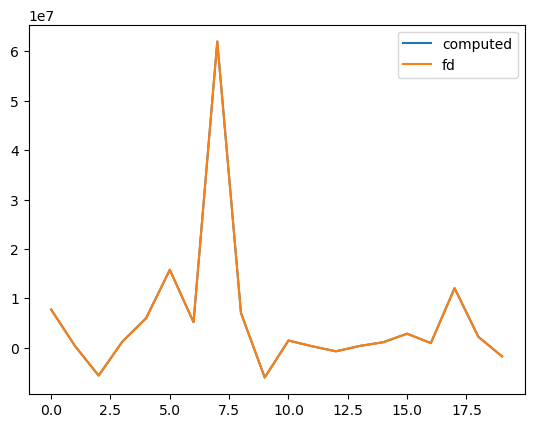

In [9]:
# gradient test
h = 1e-8

k  = G.shape[1]
zt = np.random.randn(2*k)
yt = np.random.randn(A.shape[0])

obj = lambda z : objective(z, yt, A, G)

val, grad = obj(zt)

grad_fd = np.zeros(2*k)
for i in range(2*k):
    e = np.zeros(2*k)
    e[i] = 1
    
    grad_fd[i] = (obj(zt+h*e)[0] - obj(zt-h*e)[0])/(2*h)

print(np.linalg.norm(grad_fd - grad) / np.linalg.norm(grad))

plt.plot(grad, label='computed')
plt.plot(grad_fd, label='fd')
plt.legend()

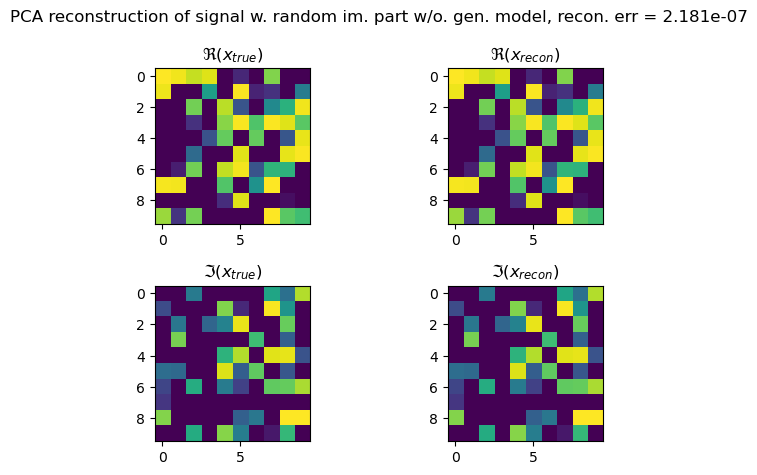

In [12]:
# reconstruct with generative model and plot result


# show that for H, the difference between G(zhat) and xhat is substantial
# x1x2 = result.x[:k+n] + 1j*result.x[k+n:]
# zhat = x1x2[:k]
# x2 = x1x2[k:]
# print(x2.shape)
# print(np.mean(np.abs(G.eval(zhat) - xhat)))
# print(min(np.abs(G.eval(zhat) - xhat)))
# print(max(np.abs(G.eval(zhat) - xhat)))

# plot_result(xtrue, xhat)

xtrue2 = G.eval(np.random.randn(k) + 1j*np.random.randn(k))
error, xhat2, yobs, result = reconstruct(xtrue2, A, G)

# plot_result(xtrue2, xhat2)

#x_imag = np.load('autoenc(x)_ex1.npy')

#x_test = np.load('G(z)_ex8_goodex.npy')
#x_autoenc = np.load('autoenc(G(z))_ex2.npy')

#x_test = G.eval(np.random.randn(k) + 1j*np.random.randn(k))

#x_test = np.zeros(n) + 1j*np.imag(x_imag)

phases = np.random.uniform(0, 2*np.pi, n)
x_test = np.exp(1j*phases)

sigma = 1e-4

error_pca, xhat_pca, _, _ = reconstruct(x_test, A, I, w = 1, sigma = sigma, lmbda = sigma)

fig, ax = plt.subplots(2,2)

ax[0,0].imshow(np.real(x_test.reshape((nx,nx))),clim=[0,1])
ax[0,0].set_title(r'$\Re(x_{true})$')
ax[1,0].imshow(np.imag(x_test.reshape((nx,nx))),clim=[0,1])
ax[1,0].set_title(r'$\Im(x_{true})$')
ax[0,1].imshow(np.real(xhat_pca.reshape((nx,nx))),clim=[0,1])
ax[0,1].set_title(r'$\Re(x_{recon})$')
ax[1,1].imshow(np.imag(xhat_pca.reshape((nx,nx))),clim=[0,1])
ax[1,1].set_title(r'$\Im(x_{recon})$')

fig.suptitle(rf"PCA reconstruction of signal w. random im. part w/o. gen. model, recon. err = {error_pca:.3e}")
fig.tight_layout()

In [16]:
# scan over noise levels with and without generative model on in-distribution gt
ns     = 10
sigmas = np.logspace(-6,6,10)

errors_i = np.zeros((len(sigmas),ns))
xhats_i  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_g = np.zeros((len(sigmas),ns))
xhats_g  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_c = np.zeros((len(sigmas),ns))
xhats_c  = np.zeros((len(sigmas),ns, n),dtype='complex')

x_import = np.load('random_ex.npy')

for i in range(len(sigmas)):
    for j in range(ns):
        #ztrue = np.random.randn(k) + 1j*np.random.randn(k) # normal
        ztrue = np.random.uniform(0,2,k) + 1j*np.random.uniform(0,2,k) # uniform
        
        xtrue = G.eval(ztrue)
        #xtrue = x_import[i,j,:]

        errors_i[i,j], xhats_i[i,j,:], _, _ = reconstruct(xtrue, A, I, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_g[i,j], xhats_g[i,j,:], _, _ = reconstruct(xtrue, A, G, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_c[i,j], xhats_c[i,j,:], _, _ = reconstruct(xtrue, A, H, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i])

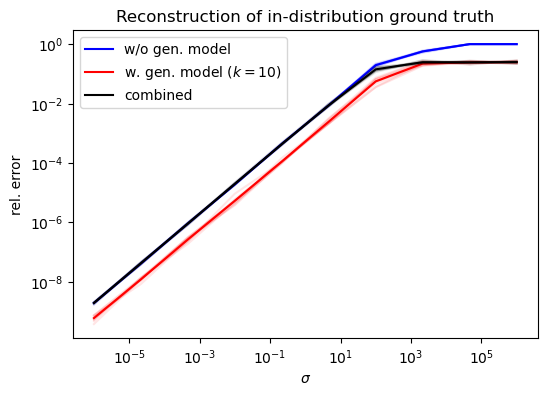

In [17]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(sigmas, np.mean(errors_i,axis=1), 'b', label='w/o gen. model')
ax.loglog(sigmas, errors_i, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_g,axis=1), 'r', label='w. gen. model ($k=$%d)'%k)
ax.loglog(sigmas, errors_g, 'r', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='combined')
ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('Reconstruction of in-distribution ground truth')
ax.legend()

#plt.savefig('MNIST_100_PCA_indistribution.png', dpi=300)

In [26]:
# scan over noise levels with and without generative model on out-of-distribution gt
ns     = 10
sigmas = np.logspace(-6,6,10)

errors_i = np.zeros((len(sigmas),ns))
xhats_i  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_g = np.zeros((len(sigmas),ns))
xhats_g  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_c = np.zeros((len(sigmas),ns))
xhats_c  = np.zeros((len(sigmas),ns, n),dtype='complex')

for i in range(len(sigmas)):
    for j in range(ns):
        #xtrue = X_test[np.random.randint(0,X_test.shape[0])]

        phases = np.random.uniform(0, 2*np.pi, n)
        xtrue = np.exp(1j*phases)

        errors_i[i,j], xhats_i[i,j,:], _, _ = reconstruct(xtrue, A, I, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_g[i,j], xhats_g[i,j,:], _, _ = reconstruct(xtrue, A, G, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_c[i,j], xhats_c[i,j,:], _, _ = reconstruct(xtrue, A, H, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i])

val 1245026076.4606555
first element gradc (23461339.255497012+23337392.775209736j)
val 924812324.5741633
first element gradc (18741316.217438754+18628353.787876815j)
val 222549691.72657675
first element gradc (6194903.6008033985+6123696.205427357j)
val 93736737.1220626
first element gradc (2929572.492174386+2877261.218081058j)
val 42868603.69429295
first element gradc (1202280.874571158+1165045.195607209j)
val 28385763.87923759
first element gradc (512965.9009976157+484097.79539528023j)
val 23872858.344400927
first element gradc (207924.0216707793+182349.18878495696j)
val 22483704.11711543
first element gradc (79149.16548056074+50695.12113029382j)
val 21702386.889118735
first element gradc (21755.88525502463-20902.681759857183j)
val 18712151.026681032
first element gradc (24272.171126313468-90268.70749785735j)
val 54872158.16526018
first element gradc (-495851.2476914325-408837.21469706524j)
val 14172086.770447947
first element gradc (132722.5573708291-34672.87892514814j)
val 13318510

KeyboardInterrupt: 

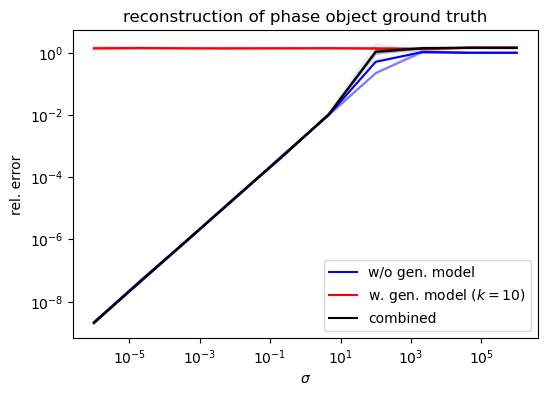

In [ ]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(sigmas, np.mean(errors_i,axis=1), 'b', label='w/o gen. model')
ax.loglog(sigmas, errors_i, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_g,axis=1), 'r', label='w. gen. model ($k=$%d)'%k)
ax.loglog(sigmas, errors_g, 'r', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='combined')
ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('reconstruction of phase object ground truth')

ax.legend()
#plt.savefig('MNIST_100_PCA_outdistribution.png', dpi=300)

In [38]:
## bias experiments
# different samples for computing bias as the z0-term for in and out-distribution
ns     = 10

errors_in = np.zeros(ns)
xhats_in  = np.zeros((ns, n),dtype='complex')

errors_out = np.zeros(ns)
xhats_out  = np.zeros((ns, n),dtype='complex')


for j in range(ns):
    x_in = G.eval(np.random.randn(k) + 1j*np.random.randn(k))
    x_out = X_test[np.random.randint(0,X_test.shape[0])]

    errors_in[j], xhats_in[j,:], _, _ = reconstruct(x_in, I, G, w=1, sigma=0, lmbda=0)
    errors_out[j], xhats_out[j,:], _, _ = reconstruct(x_out, I, G, w=1, sigma=0, lmbda=0)

print(f"%Mean bias in-distr {np.mean(errors_in):.8e}  |  Std dev {np.std(errors_in):.6e}")
print(f"%Mean bias out-distr {np.mean(errors_out):.8e}  |  Std dev {np.std(errors_out):.6e}")

%Mean bias in-distr 2.61136878e-09  |  Std dev 1.527592e-09
%Mean bias out-distr 1.15044213e-01  |  Std dev 1.395550e-02


In [45]:
## bias experiments
# different samples for computing bias as the z0-term for in-distribution and varying its misspecification
ns     = 10
etas = np.logspace(-6,6,10)

bias_in = np.zeros((len(etas),ns))
xhats_in  = np.zeros((len(etas),ns, n),dtype='complex')

for i in range(len(etas)):
    for j in range(ns):
        x_in = G.eval(np.random.randn(k) + 1j*np.random.randn(k))
        art = etas[i]*(np.random.randn(n)+1j*np.random.randn(n))

        x_pert = x_in + art
        print(art)

        bias_in[i,j], xhats_in[i,j,:], y_obs_in, _ = reconstruct(x_pert, I, G, w=1, sigma=0, lmbda=0)

for i in range(len(etas)):
    print(f"For eta level {etas[i]:.8e}  |  Mean bias {np.mean(bias_in[i, :]):.6e}")

[ 1.88938928e-07-1.47297603e-06j -7.18998959e-07-5.65975948e-07j
  1.79709778e-06-2.19271636e-06j  1.20353242e-06-1.34480297e-06j
 -3.81133794e-07+1.83745514e-06j -1.78288544e-06-1.07091531e-06j
 -2.08290268e-07+1.00885730e-07j -1.42117955e-06-7.72130404e-07j
  1.32362799e-06-1.14589300e-06j  1.74802953e-06-1.39014292e-07j
  1.17369113e-06+1.43162049e-07j  3.90384427e-07-2.37225619e-07j
 -4.79011650e-07-1.21295950e-06j -1.27306141e-06-4.77505421e-07j
  8.64306614e-07+7.79071723e-07j -1.46429279e-07+4.19385230e-07j
 -7.76807726e-07-2.21629390e-06j -4.03870328e-07+5.66478200e-07j
  8.01028888e-07+5.64287423e-07j  3.54318722e-07+1.82847469e-07j
  1.58109512e-06+1.41821555e-07j  1.27758785e-06+4.10732667e-07j
 -5.88829414e-07-9.99945772e-08j  3.92932477e-07+8.00452572e-07j
  2.91250131e-07-8.50449914e-07j -1.64744367e-07-1.49309751e-06j
  2.18916653e-06+1.22453621e-06j  1.30156175e-07+2.00875410e-07j
  4.03081446e-07+2.81225103e-07j  1.54867717e-06+1.34723329e-06j
 -1.40287560e-06+1.929774

In [67]:
## bias experiments
# different samples for computing bias as the z0-term for in-distribution and varying its misspecification
ns2     = 10
etas2 = np.logspace(-6,6,10)

bias_in2 = np.zeros((len(etas2),ns2))
bias_unnormalized2 = np.zeros((len(etas2),ns2))
z_differences2 = np.zeros((len(etas2),ns2))
xhats_in2  = np.zeros((len(etas2),ns2, n),dtype='complex')
zhats_in2  = np.zeros((len(etas2),ns2, k),dtype='complex')

ztrue_in2 = np.zeros((len(etas2),ns2,k), dtype='complex')

for i in range(len(etas2)):
    for j in range(ns2):
        ztrue2 = np.random.randn(k) + 1j*np.random.randn(k) #normal
        #ztrue = np.random.uniform(0,2,k) + 1j*np.random.uniform(0,2,k) #uniform

        ztrue_in2[i,j,:] = ztrue2

        x_in2 = G.eval(ztrue2)
        art = etas2[i]*(np.random.randn(n)+1j*np.random.randn(n)) # normal
        #art = etas[i]*(np.random.uniform(0,2,n)+1j*np.random.uniform(0,2,n)) # uniform

        x_pert2 = x_in2 + art

        bias_in2[i,j], xhats_in2[i,j,:], y_obs_in2, zhats_in2[i,j,:] = reconstruct(x_pert2, I, G, w=1, sigma=0, lmbda=0)

        z_differences2[i,j]= np.linalg.norm(zhats_in2[i,j,:] - ztrue_in2[i,j,:])/np.linalg.norm(ztrue_in2[i,j,:])
        bias_unnormalized2[i,j] = bias_in2[i,j]*np.linalg.norm(x_pert2)

print(f"%Mean bias in-distr {np.mean(bias_in2):.6e}  |  Std dev {np.std(bias_in2):.6e}")

%Mean bias in-distr 5.036230e-01  |  Std dev 4.552611e-01


In [45]:
for i in range(len(etas2)):
    print(f"For eta level {etas2[i]:.8e}  |  z_diff {np.mean(z_differences2[i, :]):.6e}")

For eta level 1.00000000e-03  |  z_diff 2.400842e-03
For eta level 1.00000000e+00  |  z_diff 2.220084e+00
For eta level 1.00000000e+03  |  z_diff 2.007036e+03


Text(0.5, 1.0, 'least squares minimization with prior (PCA)')

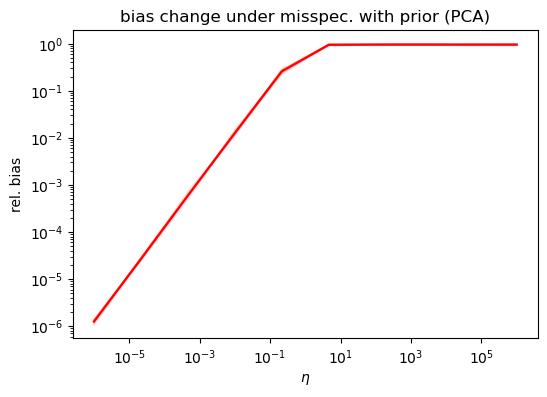

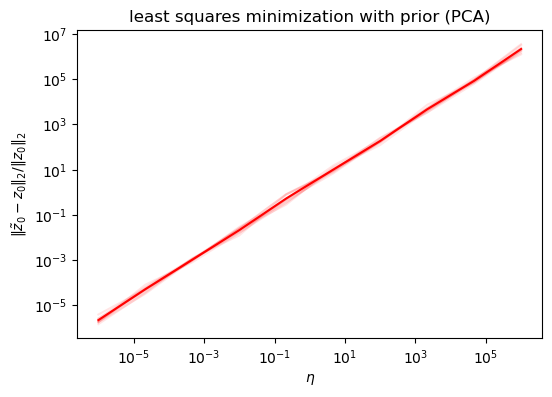

In [68]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(etas2, np.mean(bias_in2,axis=1), 'r')
ax.loglog(etas2, bias_in2, 'r', alpha=1/ns)

ax.set_xlabel(r'$\eta$')
ax.set_ylabel('rel. bias')
ax.set_title('bias change under misspec. with prior (PCA)')

#ax.legend()

fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(etas2, np.mean(z_differences2,axis=1), 'r')
ax.loglog(etas2, z_differences2, 'r', alpha=1/ns)

ax.set_xlabel(r'$\eta$')
ax.set_ylabel(r'$\| \tilde{z}_0 - z_0 \|_2 / \| z_0 \|_2$')
ax.set_title(r'least squares minimization with prior (PCA)')

In [25]:
# different samples for computing bias as the zhat-term for in and out-distribution of the H-term
ns     = 10

errors_in = np.zeros(ns)
bias_in = np.zeros(ns)
xhats_in  = np.zeros((ns, n),dtype='complex')

errors_out = np.zeros(ns)
bias_out = np.zeros(ns)
xhats_out  = np.zeros((ns, n),dtype='complex')


for j in range(ns):
    x_in = G.eval(np.random.randn(k) + 1j*np.random.randn(k))
    x_out = X_test[np.random.randint(0,X_test.shape[0])]

    errors_in[j], xhats_in[j,:], _, result_in = reconstruct(x_in, I, H, w=1, sigma=0, lmbda=1)
    errors_out[j], xhats_out[j,:], _, result_out = reconstruct(x_out, I, H, w=1, sigma=0, lmbda=1)

    x1x2_in = result_in.x[:k+n] + 1j*result_in.x[k+n:]
    x2_in = x1x2_in[k:]
    G_z_temp = xhats_in[j,:] - x2_in
    phi = np.mean(np.angle(x_in/G_z_temp)) # angle correction now has to happen outside of the reconstruct function
    G_z_in = np.exp(1j*phi)*G_z_temp
    bias_in[j] = np.linalg.norm(G_z_in - x_in)/np.linalg.norm(x_in)

    x1x2_out = result_out.x[:k+n] + 1j*result_out.x[k+n:]
    x2_out = x1x2_out[k:]
    G_z_temp = xhats_out[j,:] - x2_out
    phi = np.mean(np.angle(x_out/G_z_temp)) 
    G_z_out = np.exp(1j*phi)*G_z_temp
    bias_out[j] = np.linalg.norm(G_z_out - x_out)/np.linalg.norm(x_out)

print(f"%Mean bias in-distr {np.mean(bias_in):.6e}  |  Std dev {np.std(bias_in):.6e}")
print(f"%Mean bias out-distr {np.mean(bias_out):.6e}  |  Std dev {np.std(bias_out):.6e}")

%Mean bias in-distr 1.768410e-01  |  Std dev 1.740407e-02
%Mean bias out-distr 1.728347e-01  |  Std dev 1.684668e-02


In [69]:
# different samples for computing bias as the zhat-term for IN-distribution of the H-term for different noise
etas = np.logspace(-3,3,3)
sigmas = np.logspace(-3,3,3)
ns     = 3 # for testing

# MAYBE REDUCE THE NUMBER OF ITERATIONS AS WELL

errors_in   = np.zeros((len(etas),len(sigmas),ns))
bias_in_1   = np.zeros((len(etas),ns)) # G(z0) - x0
bias_in_2   = np.zeros((len(etas),len(sigmas),ns)) # G(ztilde) - x0
xhats_in    = np.zeros((len(etas),len(sigmas),ns,n),dtype='complex')
zcurly0_in  = np.zeros((len(etas),ns,k), dtype='complex')             #z_tilde0 from gen. approach
zcurly_in   = np.zeros((len(etas),len(sigmas),ns,k), dtype='complex') #z_tilde from combined approach
ztrue_in    = np.zeros((len(etas),ns,k), dtype='complex')             #z0

z_diff_1    = np.zeros((len(etas),len(sigmas),ns))                    #||ztilde - ztilde0 ||
z_diff_2    = np.zeros((len(etas),len(sigmas),ns))                    #||ztilde - z0 ||

for i in range(len(etas)):
    print(i)
    for j in range(ns):
        print(j)
        ztrue = np.random.randn(k) + 1j*np.random.randn(k)
        ztrue_in[i,j,:] = ztrue

        x_in = G.eval(ztrue)
        art = etas[i]*(np.random.randn(n)+1j*np.random.randn(n)) # normal
        #art = etas[i]*(np.random.uniform(0,2,n)+1j*np.random.uniform(0,2,n)) # uniform

        x_pert = x_in + art
         
        bias_in_1[i,j], _, _, zcurly0_in[i,j,:] = reconstruct(x_pert, I, G, w=1, sigma=0, lmbda=0)

        for l in range(len(sigmas)):
            print(l)
            errors_in[i,l,j], xhats_in[i,l,j,:], _, x1x2_in = reconstruct(x_pert, A, H, w=1, sigma=sigmas[l], lmbda=1)

            x2_in = x1x2_in[k:]
            zcurly_in[i,l,j,:] = x1x2_in[:k]
            G_z_temp = xhats_in[i,l,j,:] - x2_in
            phi = np.mean(np.angle(x_pert/G_z_temp)) # angle correction now has to happen outside of the reconstruct function
            G_z_in = np.exp(1j*phi)*G_z_temp

            bias_in_2[i,l,j] = np.linalg.norm(G_z_in - x_pert)/np.linalg.norm(x_pert)

            z_diff_1[i,l,j] = np.linalg.norm(zcurly_in[i,l,j,:] - zcurly0_in[i,j,:])/np.linalg.norm(ztrue_in[i,j,:]) # not sure if should normalize
            z_diff_2[i,l,j] = np.linalg.norm(zcurly_in[i,l,j,:] - ztrue_in[i,j,:])/np.linalg.norm(ztrue_in[i,j,:])
        


0
0
0
1
2
1
0
1
2
2
0
1
2
1
0
0
1
2
1
0
1
2
2
0
1
2
2
0
0
1
2
1
0
1
2
2
0
1
2


Text(0.5, 0.98, 'error latent vectors resulting from modelfitting (PCA)')

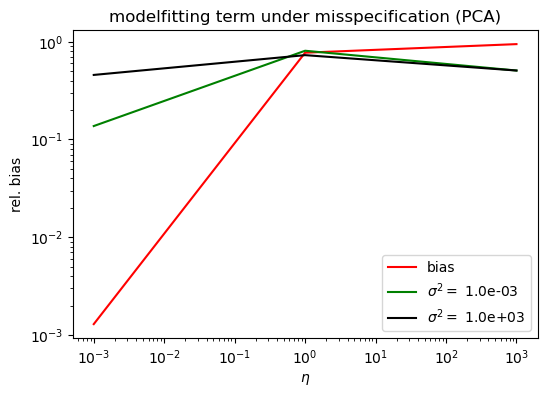

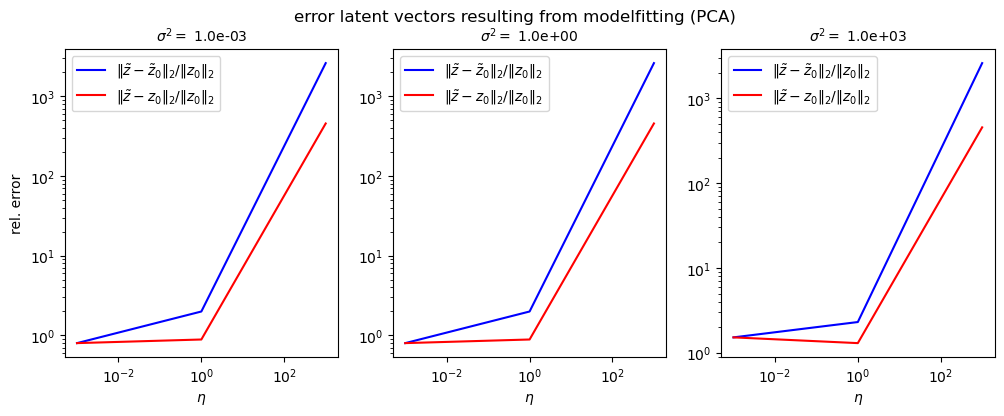

In [ ]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(etas, np.mean(bias_in_1,axis=1), 'r', label=f'bias')
#ax.loglog(etas, bias_in_1, 'r', alpha=1/ns)

ax.loglog(etas, np.mean(bias_in_2[:,0,:],axis=1), 'g', label=fr'$\sigma^2 =$ {sigmas[0]:.1e}')
#ax.loglog(etas, bias_in_2[:,0,:], 'g', alpha=1/ns)

ax.loglog(etas, np.mean(bias_in_2[:,1,:],axis=1), 'b', label=fr'$\sigma^2 =$ {sigmas[1]:.1e}')
#ax.loglog(etas, bias_in_2[:,1,:], 'b', alpha=1/ns)

ax.loglog(etas, np.mean(bias_in_2[:,2,:],axis=1), 'k', label=fr'$\sigma^2 =$ {sigmas[2]:.1e}')
#ax.loglog(etas, bias_in_2[:,2,:], 'k', alpha=1/ns)

# ax.loglog(etas, np.mean(bias_in_2[:,3,:],axis=1), 'y', label=f'sigma^2 = {sigmas[3]}')

# ax.loglog(etas, np.mean(bias_in_2[:,4,:],axis=1), 'b', label=f'sigma^2 = {sigmas[4]}')


ax.set_xlabel(r'$\eta$')
ax.set_ylabel('rel. bias')
ax.set_title('modelfitting term under misspecification (PCA)')

ax.legend()

#z_diff_1[i,l,j] = np.linalg.norm(zcurly_in[i,l,j,:] - zcurly0_in[i,j,:])/np.linalg.norm(ztrue_in[i,j,:]) # not sure if should normalize
#z_diff_1[i,l,j] = np.linalg.norm(zcurly_in[i,l,j,:] - ztrue_in[i,j,:])/np.linalg.norm(ztrue_in[i,j,:])

fig, ax = plt.subplots(1,3, figsize = (12,4))

ax[0].loglog(etas, np.mean(z_diff_1[:,0,:],axis=1), 'b', label=r'$\| \tilde{z} - \tilde{z}_0 \|_2 / \| z_0 \|_2$')
#ax[0].loglog(etas, z_diff_1[:,0,:], 'b', alpha=1/ns)
ax[0].loglog(etas, np.mean(z_diff_2[:,0,:],axis=1), 'r', label=r'$\| \tilde{z} - z_0 \|_2 / \| z_0 \|_2$')
#ax[0].loglog(etas, np.mean(z_differences2, axis=1), 'k', label=r'$\| \tilde{z}_0 - z_0 \|_2 / \| z_0 \|_2$')
ax[0].set_title(fr'$\sigma^2 =$ {sigmas[0]:.1e}', fontsize=10)
ax[0].set_xlabel(r'$\eta$')
ax[0].set_ylabel('rel. error')
ax[0].legend()

ax[1].loglog(etas, np.mean(z_diff_1[:,1,:],axis=1), 'blue', label=r'$\| \tilde{z} - \tilde{z}_0 \|_2 / \| z_0 \|_2$')
ax[1].loglog(etas, np.mean(z_diff_2[:,1,:],axis=1), 'red', label=r'$\| \tilde{z} - z_0 \|_2 / \| z_0 \|_2$')
#ax[1].loglog(etas, np.mean(z_differences2, axis=1), 'k', label=r'$\| \tilde{z}_0 - z_0 \|_2 / \| z_0 \|_2$')
ax[1].set_title(fr'$\sigma^2 =$ {sigmas[1]:.1e}', fontsize=10)
ax[1].set_xlabel(r'$\eta$')
ax[1].legend()


ax[2].loglog(etas, np.mean(z_diff_1[:,2,:],axis=1), 'b', label=r'$\| \tilde{z} - \tilde{z}_0 \|_2 / \| z_0 \|_2$')
ax[2].loglog(etas, np.mean(z_diff_2[:,2,:],axis=1), 'r', label=r'$\| \tilde{z} - z_0 \|_2 / \| z_0 \|_2$')
#ax[2].loglog(etas, np.mean(z_differences2, axis=1), 'k', label=r'$\| \tilde{z}_0 - z_0 \|_2 / \| z_0 \|_2$')
ax[2].set_title(fr'$\sigma^2 =$ {sigmas[2]:.1e}', fontsize=10)
ax[2].set_xlabel(r'$\eta$')
ax[2].legend()

fig.suptitle('error latent vectors resulting from modelfitting (PCA)')


#ax.loglog(etas, z_diff_1[:,1,:], 'c', alpha=1/ns)

# ax.loglog(etas, np.mean(z_diff_1[:,2,:],axis=1), 'm')

# ax.loglog(etas, np.mean(z_diff_1[:,3,:],axis=1), 'g')

# ax.loglog(etas, np.mean(z_diff_1[:,4,:],axis=1), 'y')

#ax.set_xlabel(r'$\eta$')
#ax.set_ylabel(r'$\| \tilde{z}_0 - z_0 \|_2 / \| z_0 \|_2$')
#ax.set_title(r'error latent vectors from modelfitting term (PCA)')
#ax.legend()

In [10]:
# different samples for computing bias as the zhat-term for OUT-distribution of the H-term
etas = [1]
sigmas = np.logspace(-3,3,5) 
ns     = 5 # for testing

errors_in   = np.zeros((len(etas),len(sigmas),ns))
bias_in_1   = np.zeros((len(etas),ns)) # G(z0) - x0
bias_in_2   = np.zeros((len(etas),len(sigmas),ns)) # G(ztilde) - x0
xhats_in    = np.zeros((len(etas),len(sigmas),ns,n),dtype='complex')
zcurly0_in  = np.zeros((len(etas),ns,k), dtype='complex')             #z_tilde0 from gen. approach
zcurly_in   = np.zeros((len(etas),len(sigmas),ns,k), dtype='complex') #z_tilde from combined approach

z_diff_1    = np.zeros((len(etas),len(sigmas),ns))                    #||ztilde - ztilde0 ||

for i in range(len(etas)):
    for j in range(ns):
        print("j", j)

        x_pert = X_test[np.random.randint(0,X_test.shape[0])]
         
        bias_in_1[i,j], _, _, zcurly0_in[i,j,:] = reconstruct(x_pert, I, G, w=1, sigma=0, lmbda=0)

        for l in range(len(sigmas)):
            print("l", l)
            errors_in[i,l,j], xhats_in[i,l,j,:], _, x1x2_in = reconstruct(x_pert, A, H, w=1, sigma=sigmas[l], lmbda=1)

            x2_in = x1x2_in[k:]
            zcurly_in[i,l,j,:] = x1x2_in[:k]
            G_z_temp = xhats_in[i,l,j,:] - x2_in
            phi = np.mean(np.angle(x_pert/G_z_temp)) # angle correction now has to happen outside of the reconstruct function
            G_z_in = np.exp(1j*phi)*G_z_temp

            bias_in_2[i,l,j] = np.linalg.norm(G_z_in - x_pert)/np.linalg.norm(x_pert)

            z_diff_1[i,l,j] = np.linalg.norm(zcurly_in[i,l,j,:] - zcurly0_in[i,j,:])/np.linalg.norm(zcurly0_in[i,j,:]) # not sure if should normalize

j 0
l 0
l 1
l 2
l 3
l 4
j 1
l 0
l 1
l 2
l 3
l 4
j 2
l 0
l 1
l 2
l 3
l 4
j 3
l 0
l 1
l 2
l 3
l 4
j 4
l 0
l 1
l 2
l 3
l 4


C:\Users\Abel\AppData\Local\Temp\ipykernel_14892\4135340134.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


Text(0.5, 0.98, 'error latent vectors resulting from modelfitting (PCA)')

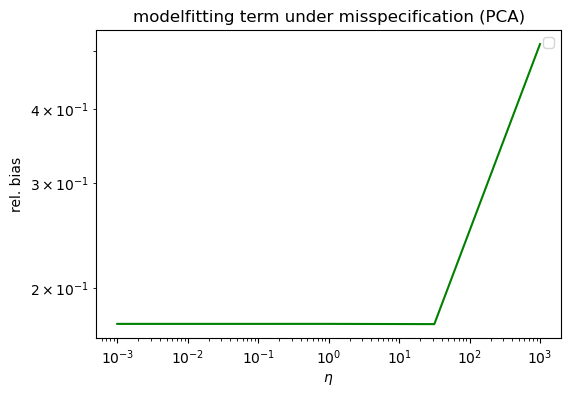

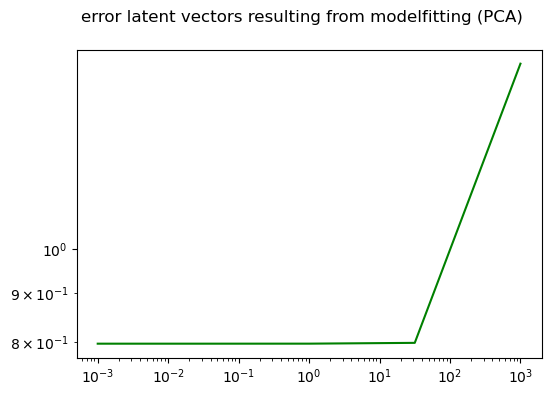

In [13]:
fig, ax = plt.subplots(1, figsize = (6,4))

#ax.loglog(etas, np.mean(bias_in_1,axis=1), 'r', label=f'bias')
#ax.loglog(etas, bias_in_1, 'r', alpha=1/ns)

ax.loglog(sigmas, np.mean(bias_in_2[0,:,:],axis=1), 'g')
#ax.loglog(etas, bias_in_2[:,0,:], 'g', alpha=1/ns)

# ax.loglog(etas, np.mean(bias_in_2[:,1,:],axis=1), 'b', label=fr'$\sigma^2 =$ {sigmas[1]:.1e}')
# #ax.loglog(etas, bias_in_2[:,1,:], 'b', alpha=1/ns)

# ax.loglog(etas, np.mean(bias_in_2[:,2,:],axis=1), 'k', label=fr'$\sigma^2 =$ {sigmas[2]:.1e}')
# #ax.loglog(etas, bias_in_2[:,2,:], 'k', alpha=1/ns)

# ax.loglog(etas, np.mean(bias_in_2[:,3,:],axis=1), 'm', label=f'$\sigma^2 =$ {sigmas[3]:.1e}')

# ax.loglog(etas, np.mean(bias_in_2[:,4,:],axis=1), 'y', label=f'$\sigma^2 =$ {sigmas[4]:.1e}')


ax.set_xlabel(r'$\eta$')
ax.set_ylabel('rel. bias')
ax.set_title('modelfitting term under misspecification (PCA)')

ax.legend()

#z_diff_1[i,l,j] = np.linalg.norm(zcurly_in[i,l,j,:] - zcurly0_in[i,j,:])/np.linalg.norm(ztrue_in[i,j,:]) # not sure if should normalize
#z_diff_1[i,l,j] = np.linalg.norm(zcurly_in[i,l,j,:] - ztrue_in[i,j,:])/np.linalg.norm(ztrue_in[i,j,:])

fig, ax = plt.subplots(figsize = (6,4))

ax.loglog(sigmas, np.mean(z_diff_1[0,:,:],axis=1), 'g')

fig.suptitle('error latent vectors resulting from modelfitting (PCA)')


#ax.loglog(etas, z_diff_1[:,1,:], 'c', alpha=1/ns)

# ax.loglog(etas, np.mean(z_diff_1[:,2,:],axis=1), 'm')

# ax.loglog(etas, np.mean(z_diff_1[:,3,:],axis=1), 'g')

# ax.loglog(etas, np.mean(z_diff_1[:,4,:],axis=1), 'y')

#ax.set_xlabel(r'$\eta$')
#ax.set_ylabel(r'$\| \tilde{z}_0 - z_0 \|_2 / \| z_0 \|_2$')
#ax.set_title(r'error latent vectors from modelfitting term (PCA)')
#ax.legend()

In [ ]:
# DELETE
ns     = 10
sigmas = np.logspace(-6,6,10)

errors_g = np.zeros((len(sigmas),ns))
xhats_g  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_c    = np.zeros((len(sigmas),ns))
xhats_c     = np.zeros((len(sigmas),ns, n),dtype='complex')
bias_out_h  = np.zeros((len(sigmas),ns))
modelfit_h  = np.zeros((len(sigmas),ns))
datafit_h   = np.zeros((len(sigmas),ns))

bias_out_1   = np.zeros((len(sigmas),ns)) # G(z0) - x0

zcurly_out   = np.zeros((len(sigmas),ns,k), dtype='complex') #z_tilde from combined approach

x_export = np.zeros((len(sigmas), ns, n), dtype='complex')
#x_import = np.load('indistribution_ex.npy')

for i in range(len(sigmas)):
    print("i:", i)
    for j in range(ns):
        print("j:", j)
        xtrue = X_test[np.random.randint(0,X_test.shape[0])]

        x_export[i,j,:] = xtrue # allows you to compare outliers later as well
        #xtrue = x_import[i,j,:]

        #errors_g[i,j], xhats_g[i,j,:], _, _ = reconstruct(xtrue, A, Astar, G, Gstar, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        #bias_in_g[i,j], _, _, zcurly0_in[i,j,:] = reconstruct(xtrue, I, Istar, G, Gstar, w=1, sigma=0, lmbda=0)

        errors_c[i,j], xhats_c[i,j,:], yobs_out, x1x2_out = reconstruct(xtrue, A, H, w=1, sigma=sigmas[i], lmbda=1) # or lambda = 1e1*sigmas[i]?

        # compute G(ztilde)
        x2_out = x1x2_out[k:]
        zcurly_out[i,j,:] = x1x2_out[:k]
        G_z_temp = xhats_c[i,j,:] - x2_out
        phi = np.mean(np.angle(xtrue/G_z_temp)) # angle correction now has to happen outside of the reconstruct function
        G_z_out = np.exp(1j*phi)*G_z_temp

        bias_out_h[i,j] = np.linalg.norm(G_z_out - xtrue)/np.linalg.norm(xtrue) # bias 2: G(ztilde) - x0
        modelfit_h[i,j] = np.linalg.norm(G_z_out - xhats_c[i,j,:])/np.linalg.norm(xtrue)  #np.linalg.norm(xhats_c[i,j,:])
        datafit_h[i,j] = np.linalg.norm(A.eval(xhats_c[i,j,:]) - yobs_out)/np.linalg.norm(A.eval(xtrue))  #np.linalg.norm(yobs_out) # no idea about the normalization
        
        bias_out_1[i,j], _, _, _ = reconstruct(xtrue, I, G, w=1, sigma=0, lmbda=0) # does not depend on noise

In [13]:
# split in a datafitting term and a modelfitting term, IN distribution
ns     = 10
sigmas = np.logspace(-6,6,10)
eta    = 1e3

errors_c    = np.zeros((len(sigmas),ns))
xhats_c     = np.zeros((len(sigmas),ns, n),dtype='complex')
bias_in_h   = np.zeros((len(sigmas),ns))
modelfit_h  = np.zeros((len(sigmas),ns))
modelfit_h_lam   = np.zeros((len(sigmas),ns))

datafit_h   = np.zeros((len(sigmas),ns))

bias_in_1   = np.zeros((len(sigmas),ns)) # G(z0) - x0

zcurly_in   = np.zeros((len(sigmas),ns,k), dtype='complex') #z_tilde from combined approach
ztrue_in    = np.zeros((len(sigmas),ns,k), dtype='complex')

#x_export = np.zeros((len(sigmas), ns, n), dtype='complex')
#x_import = np.load('indistribution_ex.npy')

for i in range(len(sigmas)):
    print("i:", i)
    for j in range(ns):
        print("j:", j)
        ztrue = np.random.randn(k) + 1j*np.random.randn(k) # normal
        ztrue_in[i,j,:] = ztrue

        #ztrue = np.random.uniform(0,2,k) + 1j*np.random.uniform(0,2,k) # uniform
        x_in = G.eval(ztrue) #here xtrue comes from the generative model
        art = eta*(np.random.randn(n)+1j*np.random.randn(n)) # normal
        xtrue = x_in + art
         
        bias_in_1[i,j], _, _, _ = reconstruct(xtrue, I, G, w=1, sigma=0, lmbda=0)

        #x_export[i,j,:] = xtrue # allows you to compare outliers later as well
        #xtrue = x_import[i,j,:]

        errors_c[i,j], xhats_c[i,j,:], yobs_in, x1x2_in = reconstruct(xtrue, A, H, w=1, sigma=sigmas[i], lmbda=10*sigmas[i])

        x2_in = x1x2_in[k:]
        zcurly_in[i,j,:] = x1x2_in[:k]
        G_z_temp = xhats_c[i,j,:] - x2_in
        phi = np.mean(np.angle(xtrue/G_z_temp)) # angle correction now has to happen outside of the reconstruct function
        G_z_in = np.exp(1j*phi)*G_z_temp

        bias_in_h[i,j] = np.linalg.norm(G_z_in - xtrue)/np.linalg.norm(xtrue)
        modelfit_h[i,j] = np.linalg.norm(G_z_in - xhats_c[i,j,:])/np.linalg.norm(xtrue) #np.linalg.norm(xhats_c[i,j,:])
        modelfit_h_lam[i,j] = 10*sigmas[i]*np.linalg.norm(G_z_in - xhats_c[i,j,:])/np.linalg.norm(xtrue)

        datafit_h[i,j] = np.linalg.norm(A.eval(xhats_c[i,j,:]) - yobs_in)/np.linalg.norm(xtrue) #np.linalg.norm(yobs_in) # no idea about the normalization


i: 0
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 1
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 2
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 3
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 4
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 5
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 6
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 7
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 8
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 9
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9


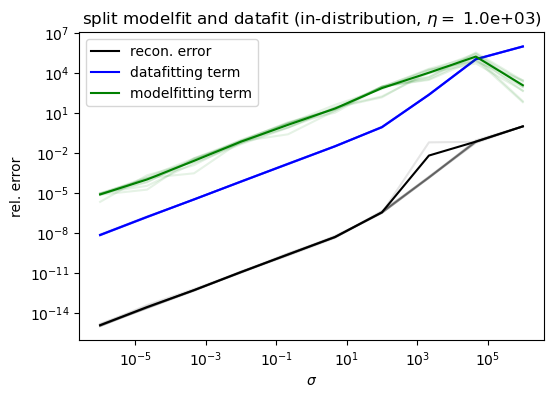

In [14]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='recon. error')
ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

# ax.loglog(sigmas, bias_in_1[:,1], 'r', label='bias')

# ax.loglog(sigmas, np.mean(bias_in_h,axis=1), 'k', label='combined bias')
# ax.loglog(sigmas, bias_in_h, 'k', alpha=1/ns)


ax.loglog(sigmas, np.mean(datafit_h,axis=1), 'b', label='datafitting term')
ax.loglog(sigmas, datafit_h, 'b', alpha=1/ns)

# ax.loglog(sigmas, np.mean(modelfit_h,axis=1), 'g', label=r'modelfitting term norm. by $\lambda$')
# ax.loglog(sigmas, modelfit_h, 'g', alpha=1/ns)

ax.loglog(sigmas, np.mean(modelfit_h_lam,axis=1), 'g', label='modelfitting term')
ax.loglog(sigmas, modelfit_h_lam, 'g', alpha=1/ns)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title(rf'split modelfit and datafit (in-distribution, $\eta = $ {eta:.1e})')
ax.legend()


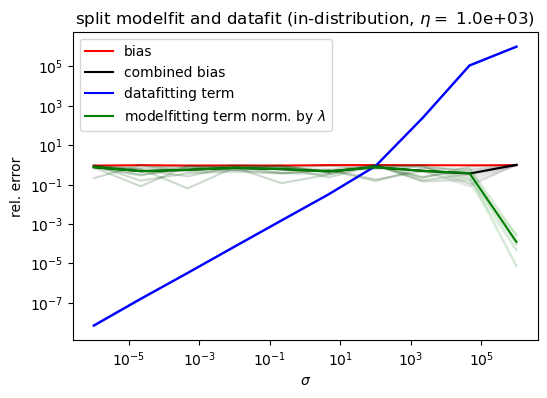

In [15]:
fig, ax = plt.subplots(1, figsize = (6,4))

# ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='recon. error')
# ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

ax.loglog(sigmas, bias_in_1[:,1], 'r', label='bias')

ax.loglog(sigmas, np.mean(bias_in_h,axis=1), 'k', label='combined bias')
ax.loglog(sigmas, bias_in_h, 'k', alpha=1/ns)


ax.loglog(sigmas, np.mean(datafit_h,axis=1), 'b', label='datafitting term')
ax.loglog(sigmas, datafit_h, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(modelfit_h,axis=1), 'g', label=r'modelfitting term norm. by $\lambda$')
ax.loglog(sigmas, modelfit_h, 'g', alpha=1/ns)

# ax.loglog(sigmas, np.mean(modelfit_h_lam,axis=1), 'g', label='modelfitting term')
# ax.loglog(sigmas, modelfit_h_lam, 'g', alpha=1/ns)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title(rf'split modelfit and datafit (in-distribution, $\eta = $ {eta:.1e})')
ax.legend()


In [17]:
# split in a datafitting term and a modelfitting term, OUT distribution
ns     = 10
sigmas = np.logspace(-6,6,10)

errors_c    = np.zeros((len(sigmas),ns))
xhats_c     = np.zeros((len(sigmas),ns, n),dtype='complex')
bias_out_h   = np.zeros((len(sigmas),ns))
modelfit_h  = np.zeros((len(sigmas),ns))
modelfit_h_lam   = np.zeros((len(sigmas),ns))

datafit_h   = np.zeros((len(sigmas),ns))

bias_out_1   = np.zeros((len(sigmas),ns)) # G(z0) - x0

zcurly_out   = np.zeros((len(sigmas),ns,k), dtype='complex') #z_tilde from combined approach

x_export = np.zeros((len(sigmas), ns, n), dtype='complex')
#x_import = np.load('indistribution_ex.npy')

for i in range(len(sigmas)):
    print("i:", i)
    for j in range(ns):
        print("j:", j)
        xtrue = X_test[np.random.randint(0,X_test.shape[0])]

        errors_c[i,j], xhats_c[i,j,:], yobs_out, x1x2_out = reconstruct(xtrue, A, H, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i]) # or lambda = 1e1*sigmas[i]?

        # compute G(ztilde)
        x2_out = x1x2_out[k:]
        zcurly_out[i,j,:] = x1x2_out[:k]
        G_z_temp = xhats_c[i,j,:] - x2_out
        phi = np.mean(np.angle(xtrue/G_z_temp)) # angle correction now has to happen outside of the reconstruct function
        G_z_out = np.exp(1j*phi)*G_z_temp

        bias_out_h[i,j] = np.linalg.norm(G_z_out - xtrue)/np.linalg.norm(xtrue) # bias 2: G(ztilde) - x0
        modelfit_h[i,j] = np.linalg.norm(G_z_out - xhats_c[i,j,:])/np.linalg.norm(xtrue)  #np.linalg.norm(xhats_c[i,j,:])
        modelfit_h_lam[i,j] = 10*sigmas[i]*np.linalg.norm(G_z_in - xhats_c[i,j,:])/np.linalg.norm(xtrue)

        datafit_h[i,j] = np.linalg.norm(A.eval(xhats_c[i,j,:]) - yobs_out)/np.linalg.norm(xtrue)  #np.linalg.norm(yobs_out) # no idea about the normalization
        
        bias_out_1[i,j], _, _, _ = reconstruct(xtrue, I, G, w=1, sigma=0, lmbda=0) # does not depend on noise

i: 0
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 1
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 2
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 3
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 4
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 5
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 6
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 7
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 8
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9
i: 9
j: 0
j: 1
j: 2
j: 3
j: 4
j: 5
j: 6
j: 7
j: 8
j: 9


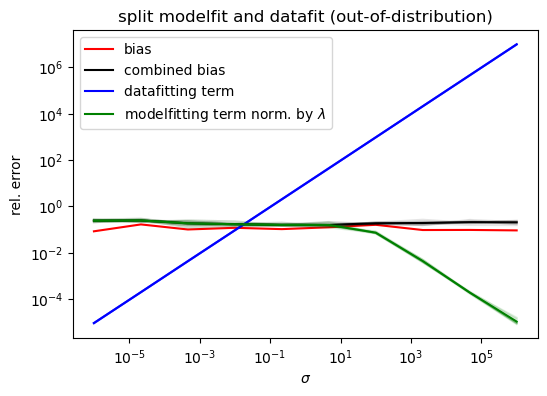

In [22]:
fig, ax = plt.subplots(1, figsize = (6,4))


# ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='recon. error')
# ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

ax.loglog(sigmas, bias_out_1[:,1], 'r', label='bias')

ax.loglog(sigmas, np.mean(bias_out_h,axis=1), 'k', label='combined bias')
ax.loglog(sigmas, bias_out_h, 'k', alpha=1/ns)

ax.loglog(sigmas, np.mean(datafit_h,axis=1), 'b', label='datafitting term')
ax.loglog(sigmas, datafit_h, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(modelfit_h,axis=1), 'g', label=r'modelfitting term norm. by $\lambda$')
ax.loglog(sigmas, modelfit_h, 'g', alpha=1/ns)

# ax.loglog(sigmas, np.mean(modelfit_h_lam,axis=1), 'g', label='modelfitting term')
# ax.loglog(sigmas, modelfit_h_lam, 'g', alpha=1/ns)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('split modelfit and datafit (out-of-distribution)')
ax.legend()


In [39]:
def Lipschitz_est(A, G, samp_amount):
    lip_const_list = []
    perturb_range = [10,1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
    k = G.shape[1]

    x_vals = np.linspace(-10,10,5)
    y_vals = np.linspace(-10,10,5)
    grid_points = [complex(x,y)*np.ones(k) for x in x_vals for y in y_vals]  # 25 total

    for x_lip in grid_points:
        for i in range(samp_amount):
            for j in perturb_range:
                perturb = np.random.normal(0,j,k) + 1j*np.random.normal(0,j,k)
                x_pert = np.linalg.norm(perturb)
                Func_pert = np.linalg.norm((A.eval(G.eval(x_lip)) - A.eval(G.eval(x_lip+perturb))))
                Lip = Func_pert / x_pert
                lip_const_list.append(Lip)

    return lip_const_list

In [40]:
# for G
lip_const_G = Lipschitz_est(I,G,100)
print(np.max(lip_const_G))
print(np.min(lip_const_G))

# for A
lip_const_A = Lipschitz_est(A,I,100)
print(np.max(lip_const_A))
print(np.min(lip_const_A))

# for A \circ G
lip_const_AG = Lipschitz_est(A,G,100)
print(np.max(lip_const_AG))
print(np.min(lip_const_AG))

0.7538833733943058
0.39638781223126696
24332.321004799684
0.0008691949114732864
3684.4569383459593
270.23876619254156
